In [1]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [2]:
import sys
import pandas as pd
import time
import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from nanoHUB.application import Application

application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')
wang159_myrmekes_db = application.new_db_engine('rfm_data')

salesforce = application.new_salesforce_engine()
db_s = salesforce

nanoHUB - Serving Students, Researchers & Instructors
Obtained Salesforce access token ...... True


## User Lifetime Comparison

In [5]:
#pull jos_users with the previously found self-study, classroom, and research users
#then just compare the register vs last visit date

In [6]:
import os
cwd = os.getcwd()

In [7]:
class_df = pd.read_csv(cwd+'/cached_data/class_ids.csv')
ss_df = pd.read_csv(cwd+'/cached_data/ss_ids.csv')
research_df = pd.read_csv(cwd+'/cached_data/researcher_ids.csv')

In [8]:
display(class_df.head(2))
display(ss_df.head(2))
display(research_df.head(2))

,Unnamed: 0,nhid,username
0,0,3013,mmc
1,1,3482,gekco


,Unnamed: 0,nhid,username
0,0,211547,-100005
1,1,211574,-100024


,Unnamed: 0,nhid
0,0,1742
1,1,1767


In [9]:
sql_query = "select registerDate, lastvisitDate from jos_users where username in " + str(tuple(class_df['username']))

In [10]:
clustered_dates = pd.read_sql_query(sql_query,nanohub_db)
clustered_dates

,registerDate,lastvisitDate
0,2021-11-07 03:43:24,2021-11-07 03:43:24
1,2021-09-29 16:51:28,2021-11-04 04:03:23
2,2021-11-03 04:05:31,2022-01-31 05:07:05
3,2021-08-22 16:44:43,2021-08-26 08:47:19
4,2021-09-29 14:40:09,2021-11-03 01:55:26
...,...,...
1672,2021-08-31 10:26:06,2021-12-03 07:53:20
1673,2021-09-06 21:36:54,2021-10-12 03:49:55
1674,2021-09-15 07:58:52,2021-11-17 03:33:19
1675,2020-08-25 19:12:58,2021-12-06 14:52:28


In [11]:
clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]

1

In [12]:
## determine time diffs
clustered_dates2 = clustered_dates[~clustered_dates['lastvisitDate'].isna()].reset_index()
clustered_dates2['registerDate'] = pd.to_datetime(clustered_dates2['registerDate'])
clustered_dates2['lastvisitDate'] = pd.to_datetime(clustered_dates2['lastvisitDate'])
clustered_dates2['duration'] = clustered_dates2['lastvisitDate'].to_numpy() - clustered_dates2['registerDate'].to_numpy()
display(clustered_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,0,2021-11-07 03:43:24,2021-11-07 03:43:24,0 days 00:00:00
1,1,2021-09-29 16:51:28,2021-11-04 04:03:23,35 days 11:11:55


In [13]:
import numpy as np

In [14]:
clustered_dates2['duration'] = [np.round(np.log10(i.days),2) for i in clustered_dates2['duration'].to_list()]
display(clustered_dates2.head(2))
display(clustered_dates2.tail(2))

,index,registerDate,lastvisitDate,duration
0,0,2021-11-07 03:43:24,2021-11-07 03:43:24,-inf
1,1,2021-09-29 16:51:28,2021-11-04 04:03:23,1.54


,index,registerDate,lastvisitDate,duration
1674,1675,2020-08-25 19:12:58,2021-12-06 14:52:28,2.67
1675,1676,2021-09-20 22:01:34,2021-12-03 02:56:03,1.86


In [15]:
# 50 bins - log days
max_log_interval = 4 #base 10
bins = 50
# 1 day, 2 day, 3 day, 4, 5, 6, 1 week, 2 week, 1 month, 2 month, 1 year, 
bin_vals = [np.round(4/50*(i+1),2) for i in range(bins)] #these are the ending bin vals
bin_vals2 = [np.round(4/50*(i+1),2) for i in range(bins)] #these are the ending bin vals

In [16]:
clustered_user_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        clustered_user_vals.append(len(np.where((clustered_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        clustered_user_vals.append(len(np.where((clustered_dates2['duration'] > l_thresh) \
                                    & (clustered_dates2['duration'] < h_thresh))[0]))        

        

In [17]:
clustered_user_vals[0]

345

In [18]:
clustered_user_vals2 = []
for i in clustered_user_vals:
    if i != 0:
        clustered_user_vals2.append(np.log10(i))
    else:
        clustered_user_vals2.append(0)

In [19]:
## import flags and plot

In [20]:
import re

In [21]:
## read the dev_flags.txt to determine where to save
with open(cwd+'/dev_flags.txt','r') as f:
    raw_flags = f.read()
flag_pattern = re.compile(r'= \w+')
flags1 = re.findall(flag_pattern,raw_flags)    
flags_result = [i[2:] for i in flags1]
dev_flag = flags_result[0]
prod_flag = flags_result[1]

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

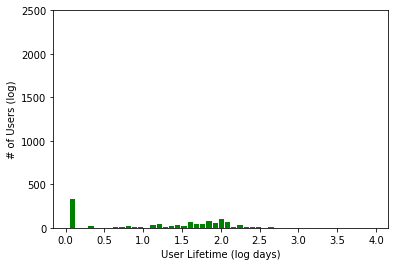

In [23]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=clustered_user_vals,align='left',color='green',edgecolor='white', linewidth=1)
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,2500])
plt.ylabel('# of Users (log)')

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/simuser_lifetime_class.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_class.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_class.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/simuser_lifetime_class.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_class.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_class.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')

In [24]:
tss_username = ss_df['username'].dropna().to_list()

In [25]:
sql_query = "select registerDate, lastvisitDate from jos_users where username in " + str(tuple(ss_df['username'].dropna()))

In [26]:
self_study_dates = pd.read_sql_query(sql_query,nanohub_db)
self_study_dates

,registerDate,lastvisitDate
0,2014-11-13 21:09:09,NaT
1,2008-11-19 22:51:04,2008-11-19 23:55:30
2,2008-11-18 17:29:56,2020-02-14 18:50:14
3,2008-11-11 19:17:04,NaT
4,2014-06-26 19:38:57,NaT
...,...,...
249510,2021-11-14 21:58:08,2021-12-10 18:51:04
249511,2021-11-14 22:07:03,2021-12-11 01:33:11
249512,2021-11-14 22:07:22,2022-01-19 22:28:33
249513,2021-11-14 22:23:48,2021-12-01 07:19:34


In [27]:
## determine time diffs
self_study_dates2 = self_study_dates[~self_study_dates['lastvisitDate'].isna()].reset_index()
self_study_dates2['registerDate'] = pd.to_datetime(self_study_dates2['registerDate'])
self_study_dates2['lastvisitDate'] = pd.to_datetime(self_study_dates2['lastvisitDate'])
self_study_dates2['duration'] = self_study_dates2['lastvisitDate'].to_numpy() - self_study_dates2['registerDate'].to_numpy()
display(self_study_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,1,2008-11-19 22:51:04,2008-11-19 23:55:30,0 days 01:04:26
1,2,2008-11-18 17:29:56,2020-02-14 18:50:14,4105 days 01:20:18


In [28]:
self_study_dates2['duration'] = [np.round(np.log10(i.days),2) for i in self_study_dates2['duration'].to_list()]
display(self_study_dates2.head(2))
display(self_study_dates2.tail(2))

,index,registerDate,lastvisitDate,duration
0,1,2008-11-19 22:51:04,2008-11-19 23:55:30,-inf
1,2,2008-11-18 17:29:56,2020-02-14 18:50:14,3.61


,index,registerDate,lastvisitDate,duration
235407,249513,2021-11-14 22:23:48,2021-12-01 07:19:34,1.2
235408,249514,2021-11-14 23:08:18,2021-11-14 23:08:19,-inf


In [29]:
self_user_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        self_user_vals.append(len(np.where((self_study_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        self_user_vals.append(len(np.where((self_study_dates2['duration'] > l_thresh) \
                                    & (self_study_dates2['duration'] < h_thresh))[0]))        

        

In [30]:
self_user_vals[:5]

[118439, 0, 0, 3535, 0]

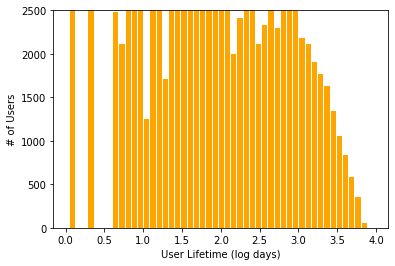

In [31]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=self_user_vals,align='left',color='orange',edgecolor='white', linewidth=1)
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,2500])
plt.ylabel('# of Users')

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/simuser_lifetime_unclass.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_unclass.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_unclass.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/simuser_lifetime_unclass.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_unclass.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_unclass.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')

In [32]:
sql_query = "select registerDate, lastvisitDate from jos_users where id in " + str(tuple(research_df['nhid']))

In [33]:
researcher_dates = pd.read_sql_query(sql_query,nanohub_db)
researcher_dates

,registerDate,lastvisitDate
0,2001-01-27 20:18:35,NaT
1,2005-07-28 01:28:13,2015-02-18 17:03:45
2,2005-07-29 18:24:36,2012-10-02 17:22:20
3,2005-02-10 07:50:17,2010-10-04 16:13:47
4,2004-09-08 03:39:55,2012-10-19 04:20:20
...,...,...
2808,2022-01-13 01:03:56,2022-01-13 06:40:13
2809,2022-01-17 10:58:18,2022-01-17 10:58:18
2810,2022-01-22 07:28:01,2022-01-22 07:28:01
2811,2022-01-22 07:33:29,2022-01-25 06:32:05


In [34]:
## determine time diffs
researcher_dates2 = researcher_dates[~researcher_dates['lastvisitDate'].isna()].reset_index()
researcher_dates2['registerDate'] = pd.to_datetime(researcher_dates2['registerDate'])
researcher_dates2['lastvisitDate'] = pd.to_datetime(researcher_dates2['lastvisitDate'])
researcher_dates2['duration'] = researcher_dates2['lastvisitDate'].to_numpy() - researcher_dates2['registerDate'].to_numpy()
display(researcher_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,1,2005-07-28 01:28:13,2015-02-18 17:03:45,3492 days 15:35:32
1,2,2005-07-29 18:24:36,2012-10-02 17:22:20,2621 days 22:57:44


In [35]:
researcher_dates2['duration'] = [np.round(np.log10(i.days),2) for i in researcher_dates2['duration'].to_list()]
display(researcher_dates2.head(2))
display(researcher_dates2.tail(2))

,index,registerDate,lastvisitDate,duration
0,1,2005-07-28 01:28:13,2015-02-18 17:03:45,3.54
1,2,2005-07-29 18:24:36,2012-10-02 17:22:20,3.42


,index,registerDate,lastvisitDate,duration
2681,2811,2022-01-22 07:33:29,2022-01-25 06:32:05,0.3
2682,2812,2022-01-23 22:00:46,2022-01-23 22:00:46,-inf


In [36]:
researcher_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        researcher_vals.append(len(np.where((researcher_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        researcher_vals.append(len(np.where((researcher_dates2['duration'] > l_thresh) \
                                    & (researcher_dates2['duration'] < h_thresh))[0]))        

        

In [37]:
researcher_vals[:2]

[708, 0]

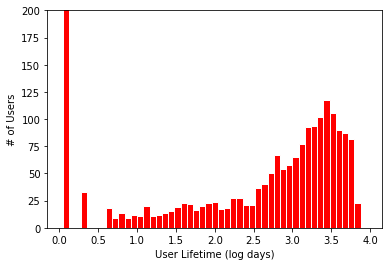

In [38]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=researcher_vals,align='left',color='red',edgecolor='white', linewidth=1)
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,200])
plt.ylabel('# of Users')

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/simuser_lifetime_research.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_research.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simuser_lifetime_research.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/simuser_lifetime_research.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_research.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simuser_lifetime_research.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')